## Import library, load data set and standardize names

In [211]:
import pandas as pd
import numpy as np

# =========================
# 0) CONFIG
# =========================
START = pd.Timestamp("2010-01-01")
END   = pd.Timestamp("2024-12-31")

# =========================
# 0) LOAD
# =========================
df_case    = pd.read_csv("../data/raw_with_coor/dengue_case_arcgis.csv")
df_weather = pd.read_csv("../data/raw_with_coor/weather_with_coor.csv")
df_mos     = pd.read_csv("../data/raw_with_coor/MosIndex_model_timeseries.csv")
df_rain    = pd.read_csv("../data/raw_with_coor/rain_with_coor.csv")
df_pop     = pd.read_csv("../data/raw/population_2024.csv")  # columns: Admin Name, 2024 Total Population, Area in Square Kilometers

# =========================
# 1) STANDARDIZE NAMES
# =========================
df_weather = df_weather.rename(columns={
    "date":"Date","city":"City",
    "pressure":"Pressure","Tmean":"Tmean","Tmin":"Tmin","Tmax":"Tmax",
    "humidity":"Humidity","windspeed":"Windspeed"
})
df_rain = df_rain.rename(columns={"date":"Date","city":"City","precip":"Precip"})
df_mos  = df_mos.rename(columns={"County":"City"})

df_pop = df_pop.rename(columns={
    "Admin Name": "City",
    "2024 Total Population": "Population_2024",
    "Area in Square Kilometers": "Area_km2"
})
for c in ["Population_2024","Area_km2"]:
    df_pop[c] = pd.to_numeric(df_pop[c], errors="coerce")

# Keep only PopDensity_km2 (drop raw population & area)
df_pop["PopDensity_km2"] = df_pop["Population_2024"] / df_pop["Area_km2"]
df_pop = df_pop[["City","PopDensity_km2"]].drop_duplicates("City")




In [212]:

# =========================
# 2) CLEAN KEYS
# =========================


def norm_city(s: str) -> str:
    return str(s).strip().replace("  ", " ")

for d in (df_case, df_weather, df_rain, df_mos, df_pop):
    if "Date" in d.columns:
        d["Date"] = pd.to_datetime(d["Date"], errors="coerce").dt.normalize()
    if "City" in d.columns:
        d["City"] = d["City"].astype(str).map(norm_city)

# fix encoding + patch mismatch
def hard_norm(s):
    return (str(s).replace("\u00a0"," ").strip().replace("  "," "))

for d in (df_case, df_weather, df_rain, df_mos, df_pop):
    if "City" in d.columns:
        d["City"] = d["City"].astype(str).map(hard_norm)

for d in (df_case, df_weather, df_rain, df_mos):
    d["City"] = d["City"].replace({"Lienchiang County (Matsu Islands)": "Lienchiang County"})
    
# 2b) DATE SLICE
# =========================
def slice_2010_2024(df):
    if "Date" in df.columns:
        return df[(df["Date"] >= START) & (df["Date"] <= END)].copy()
    return df

df_case    = slice_2010_2024(df_case)
df_weather = slice_2010_2024(df_weather)
df_mos     = slice_2010_2024(df_mos)
df_rain    = slice_2010_2024(df_rain)

## Standardize frequency case

In [213]:

# Build a full city-date index
date_range = pd.date_range(start=START, end=END, freq="D")
cities = df_case["City"].unique()

# Complete city–day grid
idx = pd.MultiIndex.from_product([ date_range, cities,], names=["Date", "City"])
df_full = pd.DataFrame(index=idx).reset_index()

# Merge dengue cases (fill missing days with 0)
df_case_day = (
    df_case.groupby(["Date", "City"], as_index=False)
           .agg(Cases=("Cases", "sum"))
)
df_full = (
    df_full.merge(df_case_day, on=["Date", "City"], how="left")
           .fillna({"Cases": 0})
           .sort_values(["City", "Date"])   # 👈 this line fixes the order
           .reset_index(drop=True)
)


df_full.head(20)

,Date,City,Cases
0,2010-01-01,Changhua County,0.0
1,2010-01-02,Changhua County,0.0
2,2010-01-03,Changhua County,0.0
3,2010-01-04,Changhua County,0.0
4,2010-01-05,Changhua County,0.0
5,2010-01-06,Changhua County,0.0
6,2010-01-07,Changhua County,0.0
7,2010-01-08,Changhua County,0.0
8,2010-01-09,Changhua County,0.0
9,2010-01-10,Changhua County,0.0


In [214]:
# ===== WEATHER (daily mean, then interpolate) =====
# Aggregate to City–Date
w_day = (df_weather.groupby(["Date", "City"], as_index=False)
                   .agg(Pressure=("Pressure","mean"),
                        Tmean=("Tmean","mean"),
                        Tmin=("Tmin","mean"),
                        Tmax=("Tmax","mean"),
                        Humidity=("Humidity","mean"),
                        Windspeed=("Windspeed","mean")))


# Full grid
grid = pd.MultiIndex.from_product([date_range, cities], names=["Date", "City"]).to_frame(index=False)


# 3) Merge to continuous City–Date frame
df_weather_full = (grid
    .merge(w_day, on=["Date","City"], how="left")
    .sort_values(["City","Date"])
    .reset_index(drop=True)
)

# make sure rows are ordered and index is simple
df_weather_full = df_weather_full.sort_values(["City","Date"]).reset_index(drop=True)

for col in ["Pressure","Tmean","Tmin","Tmax","Humidity","Windspeed"]:
    if col in df_weather_full.columns:
        df_weather_full[col] = (
            df_weather_full.groupby("City")[col]
                           .transform(lambda s: s.interpolate(limit_direction="both"))
        )

df_weather_full.head(10)

,Date,City,Pressure,Tmean,Tmin,Tmax,Humidity,Windspeed
0,2010-01-01,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
1,2010-01-02,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
2,2010-01-03,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
3,2010-01-04,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
4,2010-01-05,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
5,2010-01-06,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
6,2010-01-07,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
7,2010-01-08,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
8,2010-01-09,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99
9,2010-01-10,Changhua County,1015.43,18.36,13.8,23.6,70.96,1.99


In [215]:
# ===== RAIN (daily mean, then interpolate) =====
# 1) Aggregate to City–Date
r_day = (df_rain.groupby(["Date", "City"], as_index=False)
                 .agg(Precip=("Precip", "mean")))   # use "sum" if your rows are partial-day totals

# 2) Full grid (reuse your existing date_range, cities)
grid = pd.MultiIndex.from_product([date_range, cities], names=["Date", "City"]).to_frame(index=False)

# 3) Merge to continuous City–Date frame
df_rain_full = (grid
    .merge(r_day, on=["Date","City"], how="left")
    .sort_values(["City","Date"])
    .reset_index(drop=True)
)

# 4) Ensure numeric dtype
df_rain_full["Precip"] = pd.to_numeric(df_rain_full["Precip"], errors="coerce")

# 5) Interpolate within each City (keeps index aligned)
df_rain_full["Precip"] = (
    df_rain_full.groupby("City")["Precip"]
                .transform(lambda s: s.interpolate(limit_direction="both"))
)

# (optional) tidy types
df_rain_full["Date"] = pd.to_datetime(df_rain_full["Date"]).dt.normalize()
df_rain_full["City"] = df_rain_full["City"].astype(str)

df_rain_full.head(10)


,Date,City,Precip
0,2010-01-01,Changhua County,0.00
1,2010-01-02,Changhua County,0.06
2,2010-01-03,Changhua County,0.32
3,2010-01-04,Changhua County,0.00
4,2010-01-05,Changhua County,0.00
5,2010-01-06,Changhua County,0.08
6,2010-01-07,Changhua County,0.08
7,2010-01-08,Changhua County,0.34
8,2010-01-09,Changhua County,0.00
9,2010-01-10,Changhua County,0.00


In [216]:
# ===== MOSQUITO INDICES (daily mean, then forward-fill) =====
mos_cols = [c for c in ["BI","HI","CI"] if c in df_mos.columns]

# Aggregate to City–Date (only available columns)
m_day = (
    df_mos.groupby(["Date","City"], as_index=False)[mos_cols].mean()
    if mos_cols else
    df_mos[["Date","City"]].drop_duplicates()
)

# Full grid -> merge -> sort
df_mos_full = (
    grid.merge(m_day, on=["Date","City"], how="left")
        .sort_values(["City","Date"])
        .reset_index(drop=True)
)

# Ensure numeric before filling
for c in mos_cols:
    df_mos_full[c] = pd.to_numeric(df_mos_full[c], errors="coerce")

# Forward-fill within each City (surveys are intermittent)
for c in mos_cols:
    df_mos_full[c] = df_mos_full.groupby("City")[c].transform(lambda s: s.ffill())

# Preview
df_mos_full.head(10)


,Date,City,BI,HI,CI
0,2010-01-01,Changhua County,NaN,NaN,NaN
1,2010-01-02,Changhua County,NaN,NaN,NaN
2,2010-01-03,Changhua County,NaN,NaN,NaN
3,2010-01-04,Changhua County,1.0,1.0,2.4025
4,2010-01-05,Changhua County,1.0,1.0,2.4025
5,2010-01-06,Changhua County,0.0,0.0,0.0000
6,2010-01-07,Changhua County,1.0,1.0,2.2590
7,2010-01-08,Changhua County,0.0,0.0,0.0000
8,2010-01-09,Changhua County,0.0,0.0,0.0000
9,2010-01-10,Changhua County,0.0,0.0,0.0000


In [217]:
# ===== MERGE ALL TIME SERIES INTO ONE MASTER DATASET =====

# 1. Make sure data types are consistent
for d in [df_full, df_weather_full, df_rain_full, df_mos_full]:
    d["Date"] = pd.to_datetime(d["Date"]).dt.normalize()
    d["City"] = d["City"].astype(str)

df_pop["City"] = df_pop["City"].astype(str)

# 2. Merge step-by-step on City and Date
df_merged = (
    df_full
    .merge(df_weather_full, on=["City","Date"], how="left")
    .merge(df_rain_full,    on=["City","Date"], how="left")
    .merge(df_mos_full,     on=["City","Date"], how="left")
    .merge(df_pop,          on="City", how="left")   # population has no Date column
    .sort_values(["City","Date"])
    .reset_index(drop=True)
)

# After you build df_merged and sort by ["City","Date"]:

mos_cols = [c for c in ["BI","HI","CI","PI","AI","AIAeg","AIAlb"] if c in df_merged.columns]
wx_cols  = [c for c in ["Pressure","Tmean","Tmin","Tmax","Humidity","Windspeed"] if c in df_merged.columns]
rain_col = ["Precip"] if "Precip" in df_merged.columns else []

# Cases: keep zero for missing
if "Cases" in df_merged.columns:
    df_merged["Cases"] = df_merged["Cases"].fillna(0)

# Weather & rain: interpolate within City (both directions)
for col in wx_cols + rain_col:
    df_merged[col] = (df_merged.groupby("City")[col]
                               .transform(lambda s: s.interpolate(limit_direction="both")))

# Mosquito indices: forward-fill within City ONLY (no backfill)
for col in mos_cols:
    df_merged[col] = df_merged.groupby("City")[col].transform(lambda s: s.ffill())


# 4. Preview
df_merged.head(50)


,Date,City,Cases,Pressure,Tmean,Tmin,Tmax,Humidity,Windspeed,Precip,BI,HI,CI,PopDensity_km2
0,2010-01-01,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.00,NaN,NaN,NaN,1129.725163
1,2010-01-02,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.06,NaN,NaN,NaN,1129.725163
2,2010-01-03,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.32,NaN,NaN,NaN,1129.725163
3,2010-01-04,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.00,1.000000,1.000000,2.402500,1129.725163
4,2010-01-05,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.00,1.000000,1.000000,2.402500,1129.725163
5,2010-01-06,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.08,0.000000,0.000000,0.000000,1129.725163
6,2010-01-07,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.08,1.000000,1.000000,2.259000,1129.725163
7,2010-01-08,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.34,0.000000,0.000000,0.000000,1129.725163
8,2010-01-09,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.00,0.000000,0.000000,0.000000,1129.725163
9,2010-01-10,Changhua County,0.0,1015.43,18.36,13.8,23.6,70.96,1.99,0.00,0.000000,0.000000,0.000000,1129.725163


In [218]:


# =========================
# 3) CITY–DAY REFERENCE TABLES
# =========================
# Weather aggregated to City–Date
w_agg = (df_weather.groupby(["Date","City"], as_index=False)
         .agg(Pressure=("Pressure","mean"),
              Tmean=("Tmean","mean"),
              Tmin=("Tmin","mean"),
              Tmax=("Tmax","mean"),
              Humidity=("Humidity","mean"),
              Windspeed=("Windspeed","mean")))

# Rain aggregated to City–Date
r_agg = (df_rain.groupby(["Date","City"], as_index=False)
         .agg(Precip=("Precip","mean")))

# Cases → City–Date
if "Cases" not in df_case.columns:
    df_case["Cases"] = 1
cases_cityday = (df_case.groupby(["Date","City"], as_index=False)
                 .agg(Cases=("Cases","sum")))

# Mosquito indices → City–Date
mos_cols = [c for c in ["BI","HI","CI"] if c in df_mos.columns]
if mos_cols:
    mos_cityday = df_mos.groupby(["Date","City"], as_index=False)[mos_cols].mean()
else:
    mos_cityday = df_mos[["Date","City"]].drop_duplicates()

# Population info (only PopDensity)
pop_slim = df_pop.copy()

# =========================
# 4) CASE-LEVEL ENRICHED (for ArcGIS points)
# =========================
case_enriched = (df_case
    .merge(w_agg, on=["Date","City"], how="left", validate="many_to_one")
    .merge(r_agg, on=["Date","City"], how="left", validate="many_to_one")
    .merge(pop_slim, on="City", how="left", validate="many_to_one")
)

cols_case = [
    "Date","City","Cases","Pressure","Tmean","Tmin","Tmax",
    "Humidity","Windspeed","Precip","PopDensity_km2"
]
case_enriched_out = case_enriched[cols_case].copy()
case_enriched_out.to_csv("../data/1_dengue_cases_with_weather_rain.csv",
                         index=False, date_format="%Y-%m-%d")

# =========================
# 5) CITY–DAY ML TABLE
# =========================
df_ml_cityday = (cases_cityday
    .merge(w_agg, on=["Date","City"], how="left", validate="one_to_one")
    .merge(r_agg, on=["Date","City"], how="left", validate="one_to_one")
    .merge(mos_cityday, on=["Date","City"], how="left", validate="one_to_one")
    .merge(pop_slim, on="City", how="left", validate="many_to_one")
)

df_out = df_ml_cityday.sort_values(["Date","City"]).copy()
df_out["Date"] = pd.to_datetime(df_out["Date"])

# =========================
# 6) SAVE
# =========================
df_out.to_csv("../data/2_df_ml.csv", index=False, date_format="%Y-%m-%d")

print(f"Saved {len(case_enriched_out):,} rows to 1_dengue_cases_with_weather_rain.csv")
print(f"Saved {len(df_out):,} rows to 2_df_ml.csv")


Saved 88,901 rows to 1_dengue_cases_with_weather_rain.csv
Saved 7,146 rows to 2_df_ml.csv


In [219]:
df_case.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88901 entries, 11000 to 99900
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     88901 non-null  int64         
 1   Date           88901 non-null  datetime64[ns]
 2   City           88901 non-null  object        
 3   Longitude      88901 non-null  float64       
 4   Latitude       88901 non-null  float64       
 5   Imported_Case  88901 non-null  object        
 6   Cases          88901 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 5.4+ MB


In [220]:
df_out = df_merged.copy()

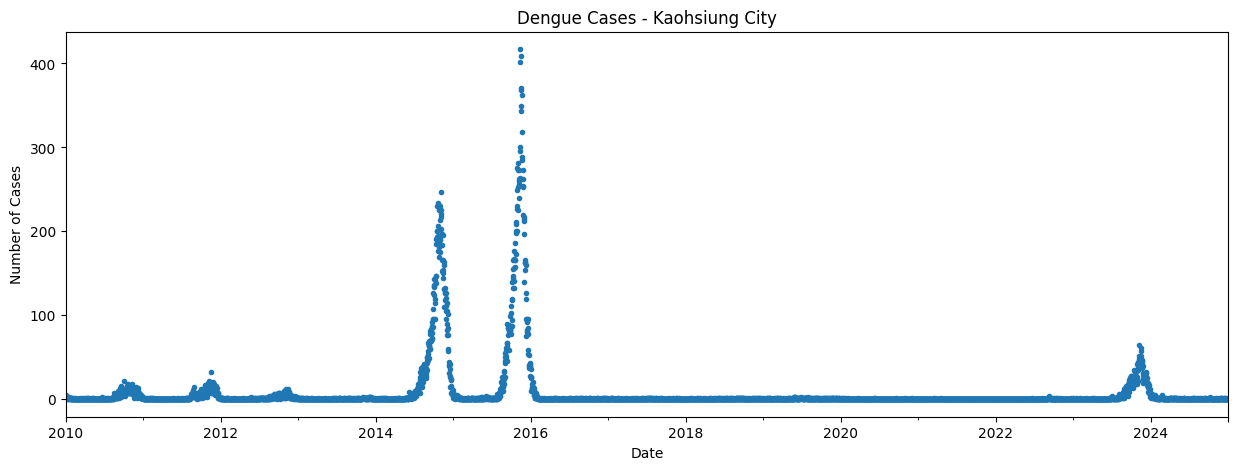

In [221]:
import matplotlib.pyplot as plt

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ensure Date is datetime and set as index
df_out["Date"] = pd.to_datetime(df_out["Date"])
df_out = df_out.set_index("Date")

# plot only the dengue cases for Kaohsiung City
df_out.loc[df_out['City'] == 'Kaohsiung City', 'Cases'].plot(
    style='.', figsize=(15, 5),
    color=color_pal[0],
    title="Dengue Cases - Kaohsiung City"
)

plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.show()


## Creating a boxplot grid for numeric features

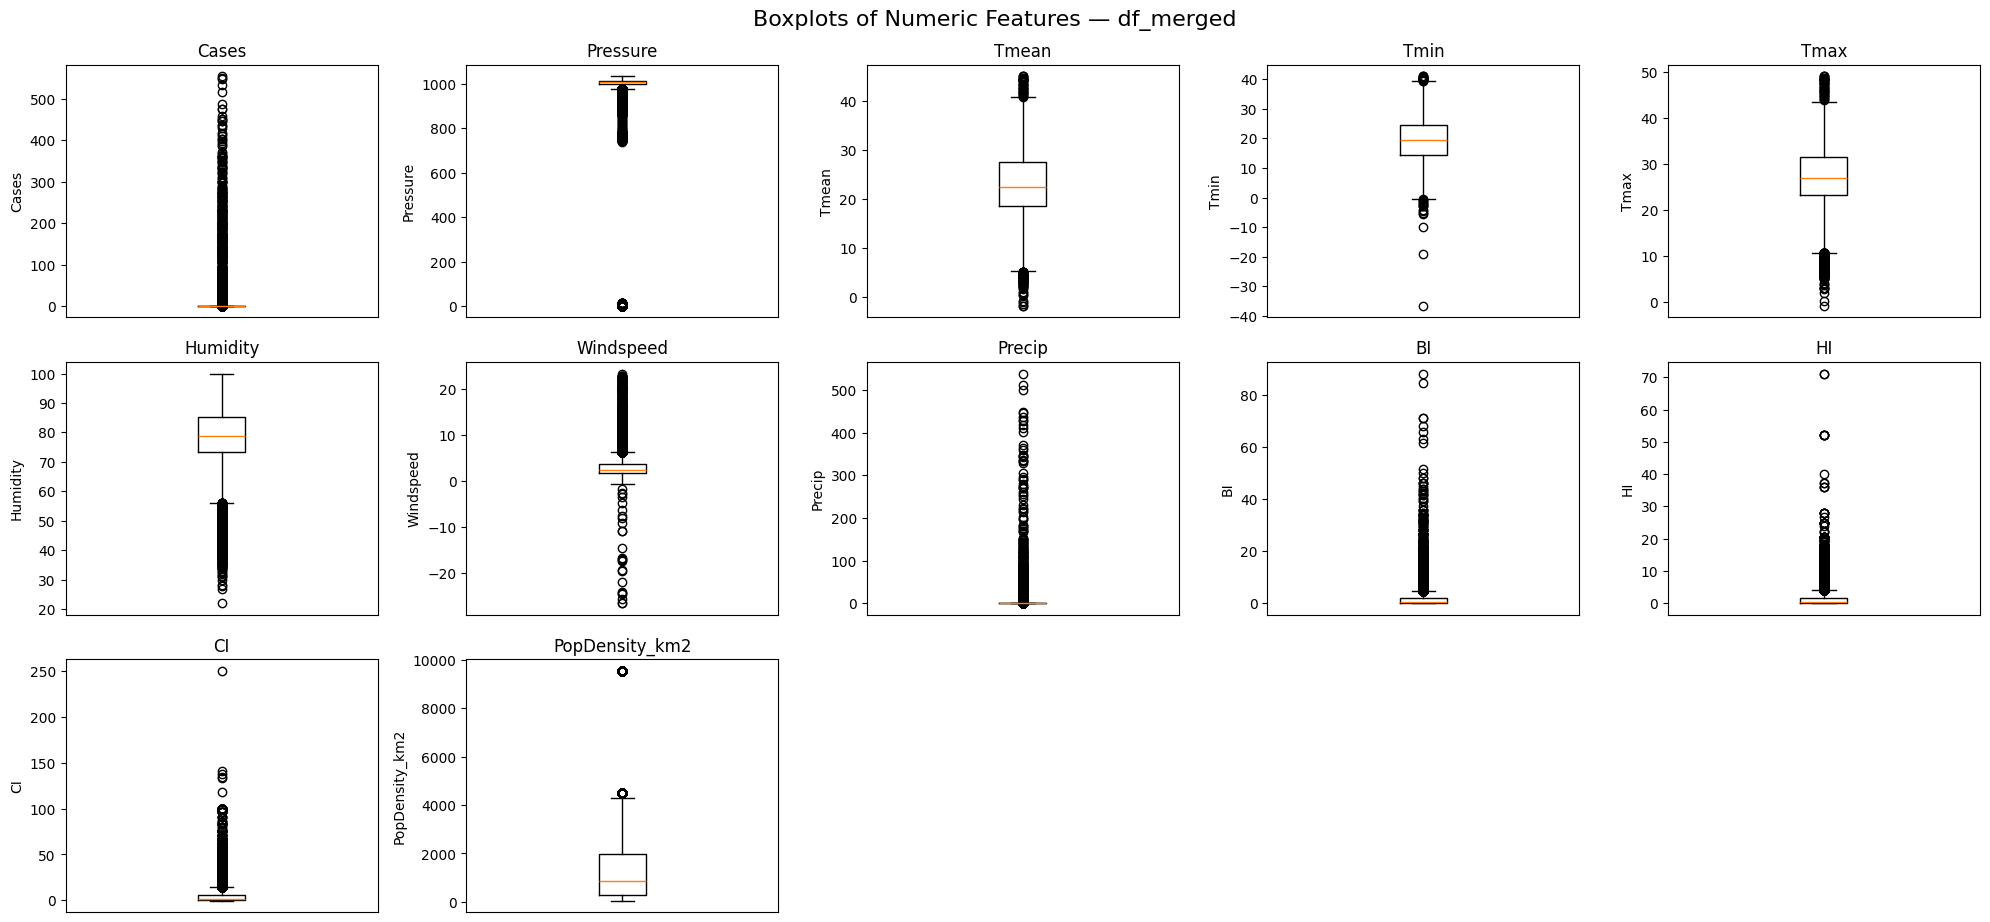

In [222]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_boxplot_grid(
    df,
    numeric_cols=None,
    cols_per_row=5,
    figsize_per_plot=(4, 3),
    title='Boxplots of Numeric Features',
    sample_n=None,         # e.g., 200_000 to speed up on very large data
    showfliers=True,       # show outliers
    vert=True              # vertical boxplots
):
    """
    Plot a grid of boxplots for numeric columns in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    numeric_cols : list[str] | None
        Columns to plot. If None, all numeric columns are used.
    cols_per_row : int
        Number of plots per row.
    figsize_per_plot : tuple
        Size per subplot (width, height).
    title : str
        Suptitle for the figure.
    sample_n : int | None
        If set, randomly sample this many rows to speed up plotting.
    showfliers : bool
        Whether to display outliers.
    vert : bool
        Vertical (True) or horizontal (False) boxplots.
    """

    # Optional sampling to speed up plotting on huge dataframes
    data = df if sample_n is None or len(df) <= (sample_n or 0) else df.sample(sample_n, random_state=42)

    # Determine numeric columns if not provided
    if numeric_cols is None:
        numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found to plot.")

    n_cols = len(numeric_cols)
    n_rows = math.ceil(n_cols / cols_per_row)

    # Create subplots
    fig, axes = plt.subplots(
        n_rows, cols_per_row,
        figsize=(cols_per_row * figsize_per_plot[0], n_rows * figsize_per_plot[1])
    )

    # Ensure axes is a 1-D array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        series = data[col].dropna().values
        if series.size == 0:
            ax.set_title(f"{col} (no data)")
            ax.axis('off')
            continue

        ax.boxplot(series, vert=vert, showfliers=showfliers)
        ax.set_title(col)
        if vert:
            ax.set_xticks([])
            ax.set_xlabel("")
            ax.set_ylabel(col)
        else:
            ax.set_yticks([])
            ax.set_ylabel("")
            ax.set_xlabel(col)

    # Hide any leftover axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Layout & title
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()
    return fig, axes

# 👉 Run it on your dataset
_ = plot_boxplot_grid(
    df_out,
    cols_per_row=5,
    figsize_per_plot=(4, 3),
    title="Boxplots of Numeric Features — df_merged",
    sample_n=200_000,      # optional: remove or adjust
    showfliers=True,
    vert=True
)


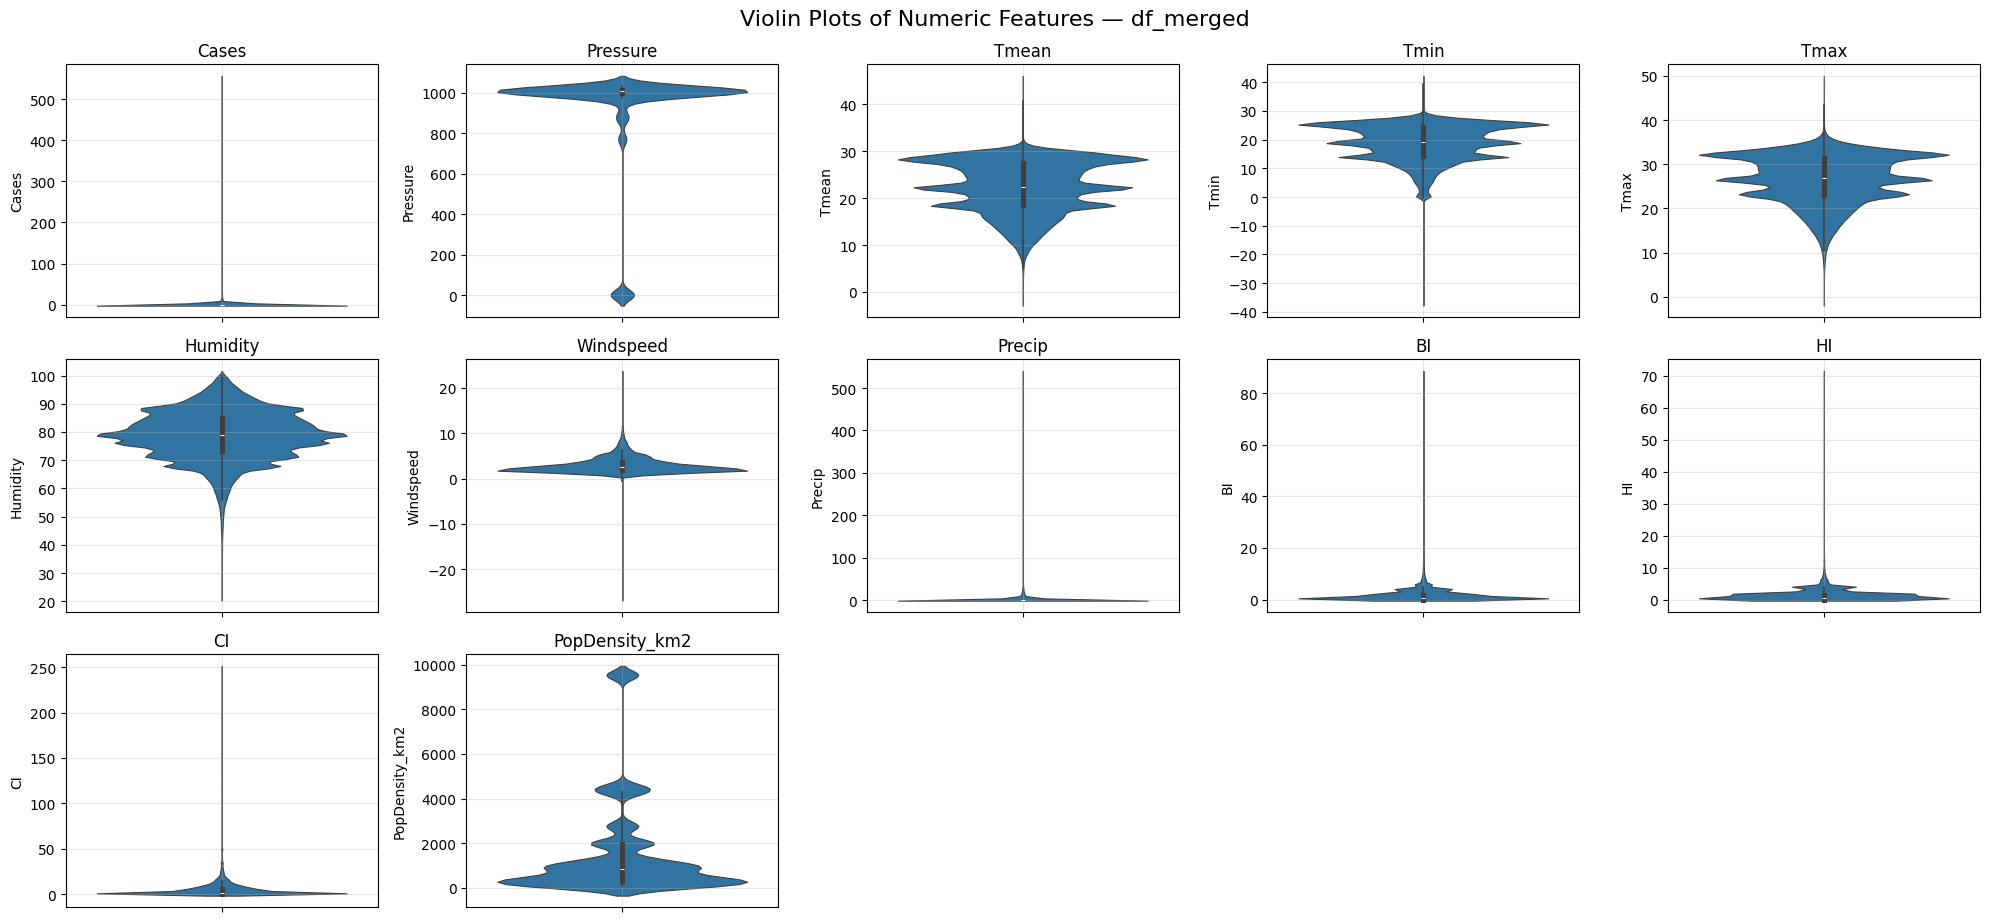

In [223]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_grid(
    df,
    numeric_cols=None,
    cols_per_row=5,
    figsize_per_plot=(4, 3),
    title='Violin Plots of Numeric Features',
    sample_n=None,
    vert=True,
    inner='box'   # options: 'box', 'quart', 'point', or None
):
    """
    Plot a grid of violin plots for numeric columns in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    numeric_cols : list[str] | None
        Columns to plot. If None, all numeric columns are used.
    cols_per_row : int
        Number of plots per row.
    figsize_per_plot : tuple
        Size (width, height) per subplot.
    title : str
        Suptitle for the figure.
    sample_n : int | None
        Randomly sample rows to speed up plotting (for large data).
    vert : bool
        Vertical (True) or horizontal (False) violins.
    inner : str
        Display inside the violin — 'box', 'quart', 'point', or None.
    """

    # Optional sampling
    data = df if sample_n is None or len(df) <= (sample_n or 0) else df.sample(sample_n, random_state=42)

    # Identify numeric columns
    if numeric_cols is None:
        numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found to plot.")

    n_cols = len(numeric_cols)
    n_rows = math.ceil(n_cols / cols_per_row)

    # Create subplot grid
    fig, axes = plt.subplots(
        n_rows, cols_per_row,
        figsize=(cols_per_row * figsize_per_plot[0], n_rows * figsize_per_plot[1])
    )

    axes = axes.flatten()

    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        sns.violinplot(y=data[col] if vert else None,
                       x=None if vert else data[col],
                       ax=ax, inner=inner, linewidth=0.8)
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel(col if vert else "")
        ax.grid(True, alpha=0.3)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()
    return fig, axes


# 🎯 Example usage for your dataset
_ = plot_violin_grid(
    df_out.reset_index(drop=True),  # 👈 add this
    cols_per_row=5,
    figsize_per_plot=(4, 3),
    title="Violin Plots of Numeric Features — df_merged",
    sample_n=200_000,
    vert=True,
    inner='box'
)


In [224]:
import numpy as np
import pandas as pd

# Make a copy to preserve the original
df_cleaned = df_out.copy()

# =========================
# WEATHER FEATURES
# =========================
# Pressure: realistic sea-level range
df_cleaned.loc[(df_cleaned["Pressure"] < 900) | (df_cleaned["Pressure"] > 1050), "Pressure"] = np.nan

# Temperature (°C)
df_cleaned.loc[(df_cleaned["Tmean"] < 0) | (df_cleaned["Tmean"] > 40), "Tmean"] = np.nan
df_cleaned.loc[(df_cleaned["Tmin"] < -5) | (df_cleaned["Tmin"] > 40), "Tmin"] = np.nan
df_cleaned.loc[(df_cleaned["Tmax"] < 0) | (df_cleaned["Tmax"] > 45), "Tmax"] = np.nan

# Humidity (%)
df_cleaned.loc[(df_cleaned["Humidity"] < 20) | (df_cleaned["Humidity"] > 100), "Humidity"] = np.nan

# Windspeed (m/s)
df_cleaned.loc[(df_cleaned["Windspeed"] < 0) | (df_cleaned["Windspeed"] > 60), "Windspeed"] = np.nan

# Precipitation (mm/day)
df_cleaned.loc[(df_cleaned["Precip"] < 0) | (df_cleaned["Precip"] > 800), "Precip"] = np.nan

# =========================
# MOSQUITO INDICES
# =========================
for col in ["BI", "HI", "CI", "PI"]:
    if col in df_cleaned.columns:
        df_cleaned.loc[(df_cleaned[col] < 0) | (df_cleaned[col] > 100), col] = np.nan

# =========================
# LOGIC CHECKS
# =========================
# Ensure Tmin ≤ Tmean ≤ Tmax
if set(["Tmin", "Tmean", "Tmax"]).issubset(df_cleaned.columns):
    mask_invalid = (df_cleaned["Tmin"] > df_cleaned["Tmean"]) | (df_cleaned["Tmean"] > df_cleaned["Tmax"])
    df_cleaned.loc[mask_invalid, ["Tmin", "Tmean", "Tmax"]] = np.nan

# =========================
# REPORT CHANGES
# =========================
diff = df_cleaned.isna().sum() - df_out.isna().sum()
changed_cols = diff[diff > 0]

print("✅ Cleaned unrealistic values in df_merged.")
if not changed_cols.empty:
    print("Columns with invalid values replaced by NaN:")
    print(changed_cols)
else:
    print("No unrealistic values found.")

# =========================
# SAVE CLEANED DATASET
# =========================
df_cleaned = df_cleaned.reset_index(drop=False)


df_cleaned.to_csv("../data/3_df_merged_cleaned.csv", index=False, date_format="%Y-%m-%d")
print(f"💾 Saved cleaned dataset with shape: {df_cleaned.shape}")


✅ Cleaned unrealistic values in df_merged.
Columns with invalid values replaced by NaN:
Pressure     17364
Tmean          936
Tmin           912
Tmax           928
Windspeed       27
CI               7
dtype: int64
💾 Saved cleaned dataset with shape: (120538, 14)


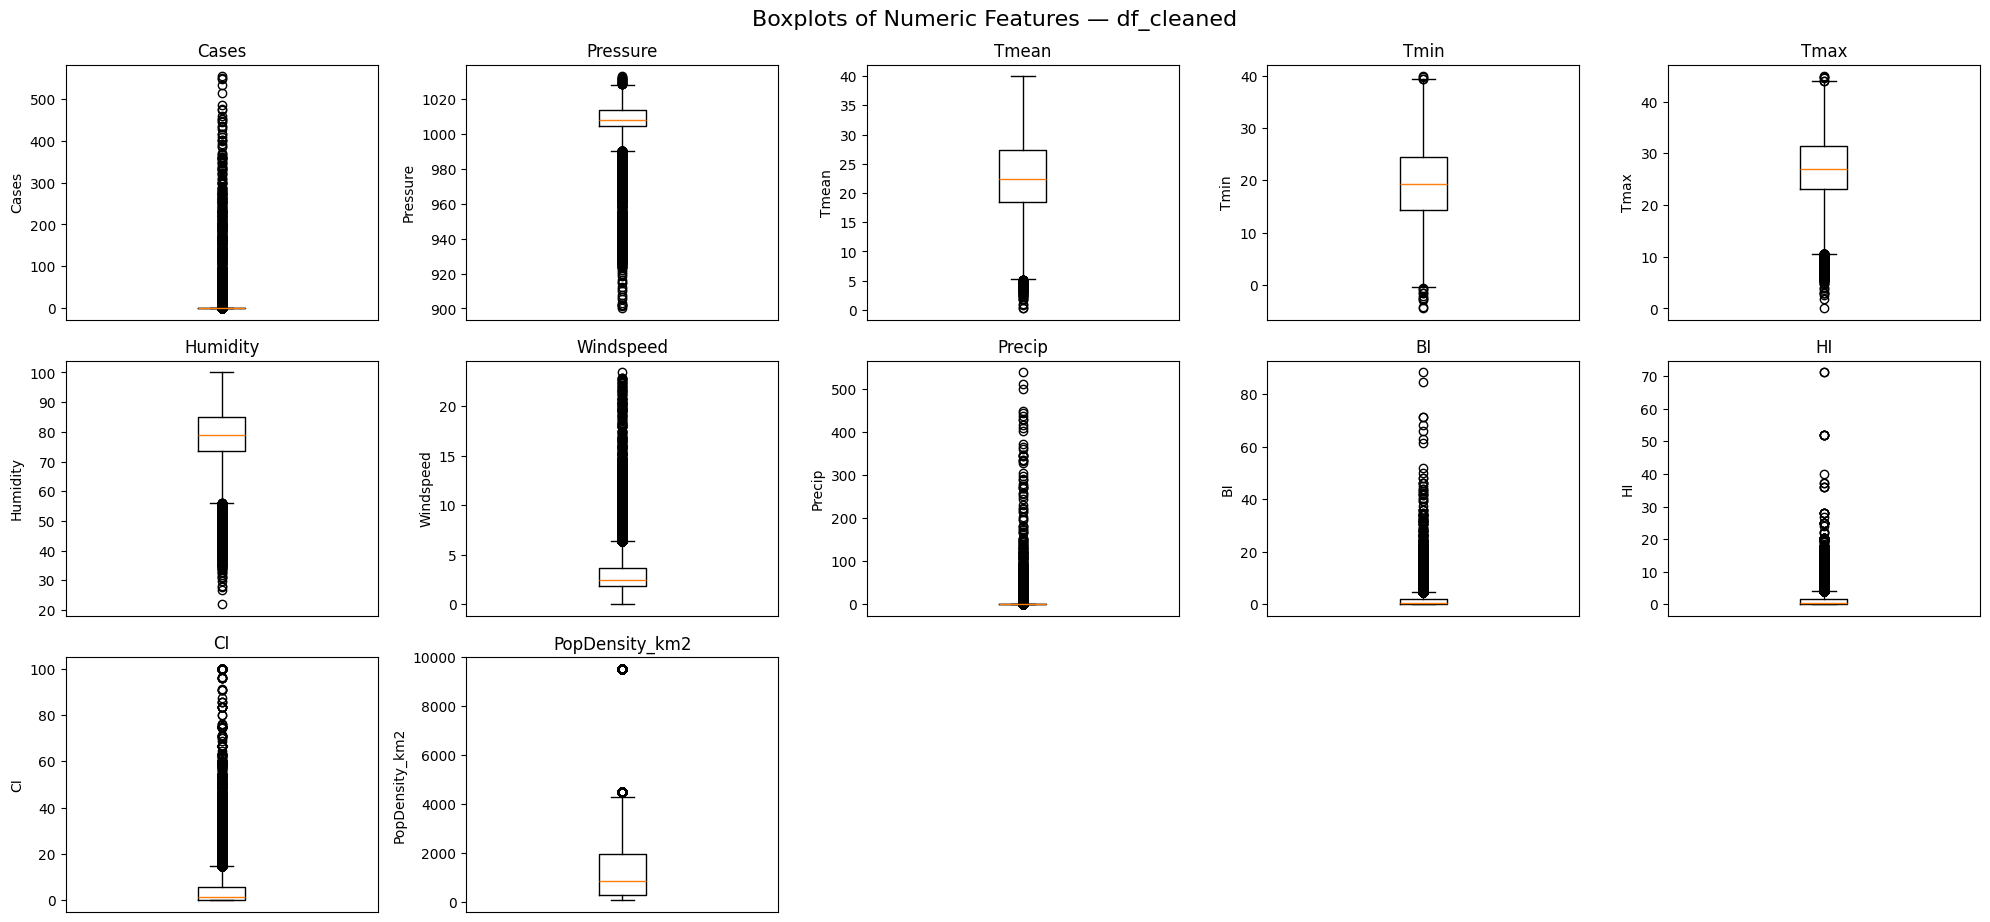

In [225]:
_ = plot_boxplot_grid(
    df_cleaned,
    cols_per_row=5,
    figsize_per_plot=(4, 3),
    title="Boxplots of Numeric Features — df_cleaned",
    showfliers=True,
    vert=True
)

## Percentage of missing value

In [226]:
(df_cleaned.isna().sum() / len(df_cleaned) * 100).sort_values(ascending=False)


Pressure          14.405416
Tmean              0.776519
Tmax               0.769882
Tmin               0.756608
CI                 0.077984
BI                 0.072176
HI                 0.072176
Windspeed          0.022400
Date               0.000000
City               0.000000
Cases              0.000000
Humidity           0.000000
Precip             0.000000
PopDensity_km2     0.000000
dtype: float64

## Metadata Report

In [227]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from pandas import CategoricalDtype

def _safe_nunique(col):
    s = col.dropna()
    try:
        return pd.unique(s).size
    except TypeError:
        # Fallback for unhashable values like lists/dicts
        return pd.unique(s.astype(str)).size

def _safe_examples(col, k=5):
    s = col.dropna()
    if s.empty:
        return []
    try:
        vals = pd.unique(s)
    except TypeError:
        vals = pd.unique(s.astype(str))
    # Normalize a few examples to printable values
    out = []
    for v in vals[:k]:
        # datetimes → ISO strings
        if isinstance(v, pd.Timestamp):
            out.append(v.isoformat())
            continue
        # hashable primitives: keep as-is
        try:
            hash(v)
            out.append(v)
        except TypeError:
            out.append(repr(v))  # lists/dicts/sets → repr
    return out

def create_metadata(df: pd.DataFrame) -> pd.DataFrame:
    meta = pd.DataFrame(index=df.columns)
    meta['dtype']        = df.dtypes
    meta['n_unique']     = [ _safe_nunique(df[c]) for c in df.columns ]
    meta['missing_sum']  = df.isnull().sum()
    meta['is_numeric']   = df.dtypes.apply(is_numeric_dtype)
    meta['is_categorical'] = df.dtypes.apply(
        lambda dt: isinstance(dt, CategoricalDtype) or is_object_dtype(dt) or is_string_dtype(dt)
    )
    meta['sample_values'] = [ _safe_examples(df[c], k=5) for c in df.columns ]
    return meta

# 🧠 Generate metadata for your dataset
meta_df = create_metadata(df_cleaned)


meta_df.to_csv("../data/4_metadata_report.csv", index=False)
print("✅ Metadata report saved as 'metadata_report.csv'")
meta_df.head()


✅ Metadata report saved as 'metadata_report.csv'


,dtype,n_unique,missing_sum,is_numeric,is_categorical,sample_values
Date,datetime64[ns],5479,0,False,False,"[2010-01-01T00:00:00.000000000, 2010-01-02T00:..."
City,object,22,0,False,True,"[Changhua County, Chiayi City, Chiayi County, ..."
Cases,float64,281,0,True,False,"[0.0, 1.0, 2.0, 3.0, 4.0]"
Pressure,float64,9184,17364,True,False,"[1015.43, 1014.83, 1014.78, 1013.69, 1012.14]"
Tmean,float64,6332,936,True,False,"[18.36, 17.83, 18.67, 17.96, 17.79]"


In [228]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120538 entries, 0 to 120537
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            120538 non-null  datetime64[ns]
 1   City            120538 non-null  object        
 2   Cases           120538 non-null  float64       
 3   Pressure        103174 non-null  float64       
 4   Tmean           119602 non-null  float64       
 5   Tmin            119626 non-null  float64       
 6   Tmax            119610 non-null  float64       
 7   Humidity        120538 non-null  float64       
 8   Windspeed       120511 non-null  float64       
 9   Precip          120538 non-null  float64       
 10  BI              120451 non-null  float64       
 11  HI              120451 non-null  float64       
 12  CI              120444 non-null  float64       
 13  PopDensity_km2  120538 non-null  float64       
dtypes: datetime64[ns](1), float64(12), o